# <b>INTRODUCTION</b>

Scrivimi

# <b>MODULES AND CONSTANTS</b>

### MODULES AND LIBRARIES

In [385]:
# GENERAL IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse

# DISTANCE FUNCTION
from sklearn.metrics.pairwise import rbf_kernel

# OUTPUT FUNCTION
from IPython.display import display, Math

### CONSTANTS

In [386]:
SPIRAL_INPUT_FILE = 'Spiral.csv'
CIRCLE_INPUT_FILE = 'Circle.csv'
EPS = 1e-24
NEIGHBORS = 10

# <b>0 - READ FUNCTIONS</b>

### <b>readSpiralInput</b>
reads the input file containing the spiral data, 
<br> accepts as input the path to the csv file containing the data
<br> returns a pandas dataFrame

In [387]:
def readSpiralInput(path:str=SPIRAL_INPUT_FILE)->pd.DataFrame:
    return pd.read_csv(filepath_or_buffer=path, header=None).set_axis(labels=['x', 'y', 'cluster'], axis=1)

### <b>readCircleInput</b>
reads the input file containing the circle data
<br> accepts as input the path to the csv file containing the data
<br> returns a pandas dataFrame

In [388]:
def readCircleInput(path:str=CIRCLE_INPUT_FILE)->pd.DataFrame:
    return pd.read_csv(filepath_or_buffer=path, header=None).set_axis(labels=['x', 'y'], axis=1)

We can print the data (since we are dealing with 2D points) to understand the spacial placement of the points and to discuss the most suited cluster algorithm

In [389]:
def plotPoint(points:pd.DataFrame, title:str=None)->None:
    plt.subplots(1,1,figsize=(10,10))
    plt.scatter(points['x'], points['y'], c=points['cluster'] if 'cluster' in points.columns else 'blue')
    plt.title('Points' or title)
    plt.show()

In [ ]:
circle = readCircleInput()
spiral = readSpiralInput()


plotPoint(spiral.drop(columns='cluster'))

# <b>1 - BUILDING $W$ SIMILARITY MATRIX </b>

Given a set of data points X and the similarity function:
$ s_{i, j} = exp\left( - \frac{||X_i - X_j||^2}{2\sigma^2}\right)$

construct the <em>k-nearest neighborhood</em> similarity graph and its adjacency
matrix $W$ using $\sigma = 1$.

In [391]:
def buildSimilarityMatrix(circle:pd.DataFrame, k:int=NEIGHBORS, sigma:int=1):
    matrix = rbf_kernel(circle, gamma=sigma/2)
    np.fill_diagonal(matrix, 0)
    
    mask = np.zeros(matrix.shape, dtype=bool)
    mask[np.arange(matrix.shape[0])[:, None], np.argpartition(-matrix, k, axis=1)[:, :k]] = True
    

    matrix = np.where(mask, matrix, 0)
    
    for i in range(matrix.shape[0]):
        for j in range(matrix[i, :].shape[0]):
            if matrix[i, j] > EPS:
                matrix[j, i] = matrix[i, j]
    
    return matrix

W = buildSimilarityMatrix(spiral[['x', 'y']], NEIGHBORS)

<h4><b>Symmetry problem</b></h4>
The main problem that may occur when building this matrix is related to the required symmetry. 

Moreover, the given matrix $W$ must be symmetric since we are dealing with a weighted, non-oriented graph. <br>
However, this may not always be the case because, even if weights are computed symmetrically (i.e., $\forall i,j, s_{i,j} = s_{j,i}$), considering the $k-nearest \text{ }neighbors$ may create asymmetry:  
If a vertex $V$ is a neighbor of $V'$, we cannot be sure of the opposite, as shown here.<br>
<b>TO ADD PICTURE </b>
<br>
To address this issue, we can use one of two approaches (relaxing the constraint of having exactly $k$ neighbors):
<ul>
    <li>Impose that if <em>V</em> is a neighbor of <em>V'</em>, then <em>V'</em> is also a neighbor of <em>V</em>, thus potentially allowing more than <em>k</em> neighbors for a single vertex.</li>
    <li>Impose that if <em>V</em> is not a neighbor of <em>V'</em>, then <em>V'</em> is also not a neighbor of <em>V</em>, thus potentially allowing fewer than <em>k</em> neighbors for a single vertex.</li>
</ul>
We have chosen the first approach.

# <b>2 - BUILD DEGREE MATRIX $D$ AND LAPLACIAN MATRIX $L$</b>

Construct the degree matrix $D$ and the Laplacian matrix $L = D − W$.

In [392]:
def buildDegreeMatrix(matrix:np)->np:
    return np.diag(matrix.sum(axis=1))

def buildLaplacianMatrix(D:np, W:np)->np:
    return D-W

### <b>setAsSparseMatrix</b>
Given a matrix as input, returns the same matrix in a sparse format. <br>
We have chosen to use an approach similar to the <b>modified CSR sparse format</b> to prioritize the diagonal of the matrix. <br>
Which is particularly convenient when dealing with matrices such as the degree matrix $D$. 

In [393]:
def setAsSparseMatrix(matrix:np)->sparse:
    return sparse.dia_array(matrix)

Finally, the Laplacian matrix is built using the previously declared function. <br>
Moreover, since we will only be working with $L$ from now on, we can convert $D$ and $W$ into a sparse matrix format. <br>
We prefer not to convert $L$ since it will still be used for many different purposes. <br>
Due to the structure of $W$ and especially $D$, we opted to convert them into a modified CSR format.

In [394]:
L = buildLaplacianMatrix(D:=buildDegreeMatrix(W), W)
D, W = setAsSparseMatrix(D), setAsSparseMatrix(W)

# <b>3 - CONNECTED COMPONENT OF THE GRAPHS </b>

Compute the number of connected components of the similarity graph.

In [ ]:
def plotLaplacian(L:np)->None:
    fig, ax = plt.subplots(figsize=(8,8))
    plt.spy(L)
    ax.set_title('Similarity graph')
    plt.show()
    
plotLaplacian(L)

First and foremost, as expected, the Laplacian matrix $L$ is symmetric. <br>
Moreover, it is a sparse matrix, with most of the non-zero elements located near the main diagonal. <br>
Finally, and most importantly, we can conclude that the graph is primarily composed of three main components (represented by the three blocks along the diagonal), which are weakly connected, as indicated by the small black patches far from the main diagonal.

# <b>4/5 - EIGENVALUES AND EIGENVECTORS OF $L$</b>

Compute some of the small eigenvalues of $L$ and use their values to choose a suitable number of clusters $M$ for the data points. <br>
From what we have previously observed, we can conclude that the graph has $3$ main components. <br>
However, we are going to compute the first $10$ eigenvalues, mainly because the graph also shows $6$ more patches with non-zero values (even though the patches are symmetric), indicating a weak connection between the $3$ main components of the graph.

## <b>USING NUMPY IMPLEMENTATION</b>

We can easily compute eigenvalues using the eig function within the linalg module of numpy.

In [ ]:
def printEigenValues(eigVal:np, legendText:str)->None:
    n = eigVal.shape[0]
    print(f"Computed the following {n} eigenvalues" )
    for i, item in enumerate(eigVal):
        display(Math(rf"\hspace{{2em}}\lambda_{{{i}}} = {item}"))

    plt.subplots(1,1,figsize=(8,8))
    plt.plot(values:=range(1, n+1), eigVal)
    plt.scatter(values, eigVal, c='red', label=legendText)
    plt.xticks(values)
    plt.ylabel("Eigenvalue")
    plt.title(f"First {n} Eigenvalues")
    plt.legend(loc='upper left')
    plt.grid(visible=True)
    plt.show()
    
printEigenValues(np.linalg.eigh(L)[0][:10], "eigenvalue's of numpy's method")

## <b>INVERSE POWER METHOD</b>

To evaluate the eigenvalues we can also implement the <b>inverse power method</b> algorithm. 
<h4><b>Theoretical aspects</b></h4>

Let $A \in R^{n,n}$, we can define $\lambda_n$ as the eigenvalue of A with smallest magnitude (i.e. $|\lambda_n| \leq |\lambda_i|, \forall i \in [1,n]$). <br>
Moreover, assuming A is invertible (and this is our case) we have that the eigenvalues of the inverse of A are the inverse of the eigenvalues of the matrix A <br>(i.e. $\forall i \in [1, n], Ax_i = \lambda_i x_i \implies A^{-1}x_i = \frac{1}{\lambda_i}x_i$ if A is invertible ).<br>
Thus implying that if $|\lambda_n| \leq |\lambda_i|, \forall i \in [1,n]$ then $\frac{1}{|\lambda_n|} \geq \frac{1}{|\lambda_i|}, \forall i \in [1,n]$ <br>
Finally, we can compute the eigenvalues by using the power method applied to the inverse of A, i.e. $A^{-1}$.
<br>
<h4><b>Algorithm</b></h4>
This is the algorithm that we are going to implement:
<ul>
<li><b>Inputs</b>: 

$A$ (matrix), $V$ (initial guess vector), $p$ (initial guess for eigenvalue), $maxIter$ (maximum iterations), $tol$ (tolerance)

</li>
<li><b>Algorithm</b>:</li>
<ol>
    <li>

Normalize the initial guess vector $ V_0 \leftarrow \frac{V_0}{\|V_0\|_2} $
</li>
<li>

Set $ \mu_0 = 0 $ and initialize $ k = 0 $.</li>
    <li>Repeat until convergence (i.e. $|\mu_k -\mu_{k-1}| \leq tol\cdot|\mu_k| $) or $ k \geq \text{maxIter} $:
        <ol type='I'>
            <li>Compute $ V_{k+1} $ by solving $ (A - pI)V_k = V_{k+1} $.</li>
            <li>Update $ \mu_{k-1} = \mu_k$ and $\mu_k = V_{k+1} * V_{k} $.</li>
            <li>Normalize $ V_{k+1} \leftarrow \frac{V_{k+1}}{\|V_{k+1}\|_2} $.</li>
            <li>Update $k \leftarrow k+1$</li>
        </ol>
    </li>
</ol>
<li><b>Outputs</b>: 

The eigenvalue $ \lambda_j = p + \frac{1}{\mu_k} $ and the eigenvector $ V_k $.
</li>
</ul>

The main issue is the fact that if we apply the inverse power method to the $L$ matrix $10$ times we are going to get the same eigenpair $10$ times.<br>
Once computed the eigenpair, we have to move it out of the way so that we may compute the remaining eigenpairs.<br>
To do so, we can use either one of two techniques: <b>Shifting</b> or <b>Deflation</b>.

<h4><b>Shifting</b></h4>

This technique can only be applied to symmetric matrix (and, luckily for us, $L$ is symmetric), this requirement is imposed so that we may deal with real eigenvalues and orthogonal eigenvectors <br>
i.e. let $A \in R^{n,n} \text{ symmetric } \implies \forall i \in [1, n], \lambda_i \in \mathbb{R}$ and $\forall j \in [1, n], x_i * x_j = \delta_{ij}$<br>
We assume knowing the eigenpair $\lambda_1, x_1$, given that eigenpair we can compute $A' = A - \lambda_1\cdot x_1 x_1^T \in R^{n,n}$ with $x_1x_1^T \in R^{n,n}$ and of rank 1. <br>
The new matrix $A'$ has the same eigenvectors of $A$ and almost the same eigenvalues, except for the first one. <br>
i.e. defining with $\lambda_i$ the eigenvalues of $A$ and $\lambda_i'$ the eigenvalues of $A'$ then $\forall i \in [2, n], \lambda_i = \lambda_i'$ and for $i=1 \lambda_i' = 0$<br>
Which implies that we have effectively created a new matrix that has the vector $\lambda_1x_1$ into it's right kernel, thus removing it from it's eigenvalues and adding $0$ as eigenvalue.<br>

When dealing with the <b>power method</b> this is sufficient, since we are always evaluating the eigenvalue with the highest magnitude (and $0$ is the lowest possible magnitude).<br>
However when dealing with the <b>inverse power method</b> this may prove counter productive since $\frac{1}{0+eps}$ (with eps due to machine precision) is going to skyrocket, thus getting in the way when calculating eigenvalues with this method. <br>
Instead we have to create $A'$ in such a way that the eigenvalue $\lambda_1$ gets a really high magnitude, such that, $\frac{1}{\lambda_1}$ becomes so low that is no longer a problem with this method. <br>
The best way to do so, in our case, is the following $A' = A + \alpha\lambda_1\cdot x_1 x_1^T$ with $ \alpha \approx 10^{15}$ 

<h4><b>Deflation</b></h4>

Let $A \in R^{n,n}$ and let $(\lambda_1, x_1)$ be an eigenpair of $A$ and let $P_1 \in R^{n,n}$ orthogonal such that: <br>
$B_1 = P_1 A P_1^T = \begin{bmatrix} \lambda_1 --- b_1 --- \\ 0 \hspace{7em} \\ | \hspace{1em} A_2  \in R^{n-1, n-1}\\ 0 \hspace{7em} \end{bmatrix} \in R^{n,n}$.<br>
The eigenvalues of $A_2$ will almost be the same of the ones of $A$, in fact, defining as $\lambda$ the eigenvalues of $A$ and as $\lambda'$ the eigenvalues of $A_2$, then, $\forall i \in [2, n], \lambda_i = \lambda_{i-1}' \implies \{\lambda'\} \cup \{\lambda_1\} = \{\lambda\}$. <br>
We have to notice that the first column of $B_1 = B_1*e_1^n = \lambda_1 \cdot e_1^n $. <br>
We can define $P_1 = I_n - 2 \frac{(x_1+e^n_1)(x_1+e^n_1)^T}{|| x_1 + e^n_1||_2}$. <br>
Moreover, we can see how once we have computed the eigenpair $(\lambda_2, x_2)$ we can use again this procedure to deflate $A_2$ being careful with using vector of size $n-1$ (i.e. $e^{n-1}_1$). <br>
Moreover, with this method, the computed eigenvalues won't vary, but eigenvectors will! <br>
To get the eigenvectors $x_i$ of $A$ we have to compute $x_i = P_1 P_2 P_3 ...P_{k-1}x_i'$.

<br><br><br>
Now we can apply the <b>Inverse power method with either deflation or shifting</b> (both solution are proposed) to $L$ to compute the first ten eigenvalues and the corresponding eigenvectors.<br>
The shape of $L$ is already pretty good, we don't have to modify it to make the algorithm more efficient.

### <b>Inverse power method</b>

In [397]:
def inversePowerMethodAlgorithm(A:np, V:np, p:float, maxIter:int=200, tol: float=EPS) -> list[float, np]:
    V = V/np.linalg.norm(V,2)
    pI = p*np.eye(A.shape[0])         # Precomputed to have a faster execution
    mu_prev, mu, k = 0, 1, 0
        
    while k < maxIter and np.abs(mu - mu_prev)>=tol*np.abs(mu):
        Vk = np.linalg.solve(A-pI, V)
        mu, mu_prev = np.dot(Vk,V), mu
        V = Vk/np.linalg.norm(Vk, 2)
        k += 1
        
    return p + 1/mu, V

#### <b>Using Shifting </b>

In [398]:
def applyInversePowerMethodWithShifting(A:np, numEig:int=10, maxIter:int=1e4, tol: float=EPS)->list[list[float], list[np]]:
    temp = A.copy()
    
    # Pre allocated for speed 
    eigVal = np.zeros(numEig+1)
    eigVecs = np.zeros((A.shape[0], numEig+1))

    for i in range(numEig+1):
        eigVal[i], eigVecs[:, i] = inversePowerMethodAlgorithm(temp, np.random.rand(A.shape[0]), p=1e-16, maxIter=maxIter, tol=tol)

        vect = eigVecs[:, i].reshape(-1, 1)
        temp += 1e8*eigVal[i] * (vect @ vect.T)  
        
    mask = [True, False] + [True]*(numEig-1)
    return eigVal[mask],eigVecs[:, mask]
    

def nothing():
    eigV, vect = np.linalg.eigh(L)

    for i,(v1,v2) in enumerate(zip(vect[:, np.argsort(eigV)[:10]].T, applyInversePowerMethodWithShifting(L)[1].T)):
        print(i)
        for j in range(v1.shape[0]):
            print(v1[j],'\t', v2[j])
        print("\n"*2)

#### <b>Using Deflation</b>

In [426]:
def applyInversePowerMethodWithDeflation(A:np, numEig:int=10, maxIter:int=1e4, tol: float=EPS)->list[list[float], list[np]]:
    matrix = A.copy()
    
    # Pre allocated for speed 
    eigVal = np.zeros(numEig)
    eigVecs = np.zeros((A.shape[0], numEig))

    # creates the tensor for storing P
    P = np.array([np.eye(matrix.shape[0])]*numEig)   # [#tensor, row, col]

    for i in range(numEig):        
        eigVal[i], eigVecs[i:, i] = inversePowerMethodAlgorithm((matrix:= P[i-1]@matrix@P[i-1].T)[i:, i:], 
                                                np.random.rand(A.shape[0]-i), p=1e-5, maxIter=maxIter, tol=tol)
    
        P[i, i:, i:]=P[i, i:, i:] - 2*(temp:=(eigVecs[i:, i].reshape(-1,1) + np.eye(N=matrix.shape[0]-i, M=1))).T*temp/np.linalg.norm(temp, 2)**2
        

    
    return eigVal, eigVecs

### <b>VISUALIZING AND COMPARING RESULTS</b>

Here we can compare the results between the two different implementations, taking numpy ones as a reference:
<ul>
<li><b>Shifting</b>: implementation of the <b>Inverse power method</b> using shifting.</li>
<li><b>Deflation</b>: implementation of the <b>Inverse power method</b> using deflation.</li>
<li><b>Numpy</b>: calculating the eigenpairs via the eig function within the linalg module of numpy.</li>
</ul>
<b>NOTE:</b> we will only compare eigenvalues and not eigenvectors due to the high dimensionality of them.

Eigenvalues calculated : 10


,shifting,deflation,numpy
λ1,8.647805e-17,8.219438e-17,-1.300642e-15
λ2,1.966691e-04,1.966691e-04,1.966691e-04
λ3,2.721948e-04,2.721948e-04,2.721948e-04
λ4,4.133882e-03,4.133882e-03,4.133882e-03
λ5,4.380812e-03,4.380812e-03,4.380812e-03
λ6,4.578309e-03,4.578309e-03,4.578309e-03
λ7,1.723718e-02,1.723718e-02,1.723718e-02
λ8,1.838614e-02,1.838614e-02,1.838614e-02
λ9,1.885387e-02,1.885387e-02,1.885387e-02
λ10,4.041494e-02,4.041494e-02,4.041494e-02


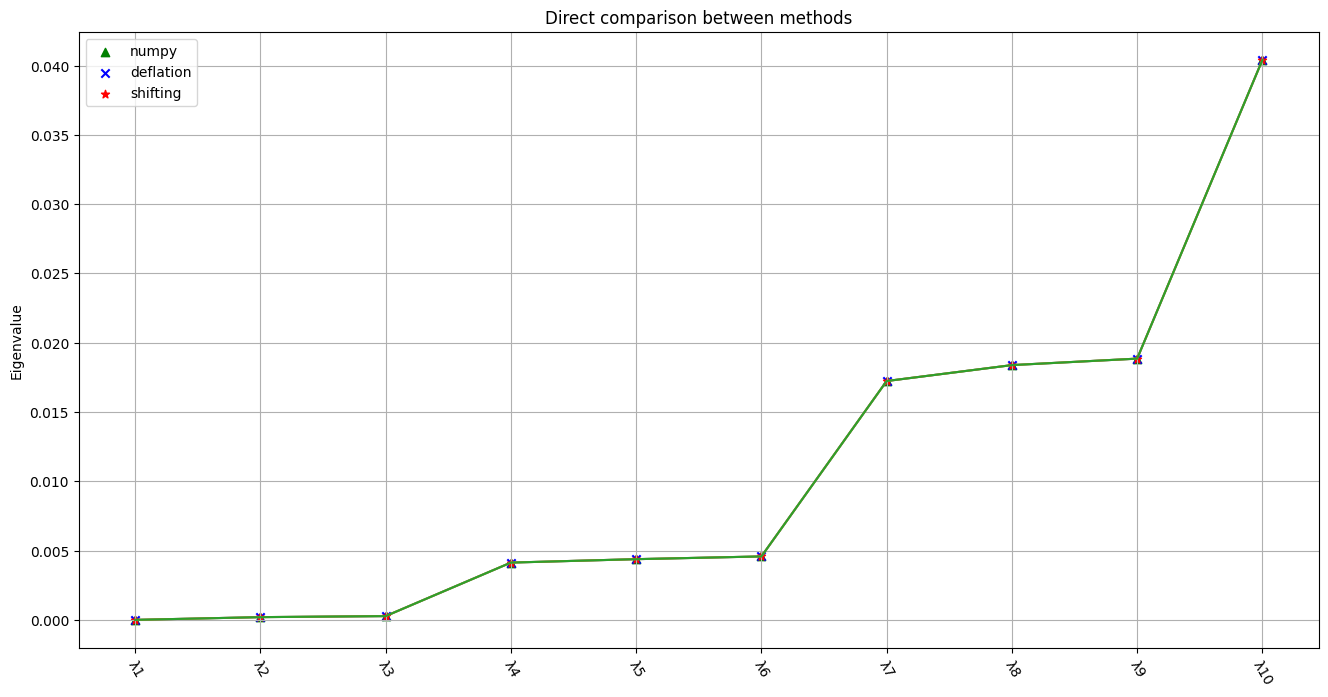

In [ ]:
def comparisonBetweenEigenvaluesMethod(df:pd.DataFrame, plotSingle:bool=False)->None:
    print(f"Eigenvalues calculated : {df.shape[0]}")
    display(df)
    param = {   'shifting':{'c':'red', 'marker':'*'}, 
                'deflation':{'c':'blue', 'marker':'x'}, 
                'numpy':{'c':'green', 'marker':'^'}}

    fig, ax = plt.subplots(1,1,figsize=(16,8))    
    for col in df.columns[::-1]:
        ax.plot(df.index, df[col])
        ax.scatter(df.index, df[col], label=col, **param[col])
        

    plt.xticks(range(df.index.shape[0]), rotation=-60)
    plt.ylabel("Eigenvalue")
    plt.title("Direct comparison between methods")
    plt.legend(loc='upper left')
    plt.grid(visible=True)
    plt.show()
    if plotSingle:
        fig, ax = plt.subplots(3,1,figsize=(8, 24))
        for i,col in enumerate(df):
            ax[i].plot(df.index, df[col])
            ax[i].scatter(df.index, df[col], label=col, **param[col])
            
            ax[i].set_xticks(range(1, df.index.shape[0]+1))
            ax[i].set_xticklabels(df.index, rotation=-60)
            ax[i].set_ylabel("Eigenvalue")
            ax[i].set_title(f"First {df.shape[0]} Eigenvalues with method {col}")
            ax[i].legend(loc='upper left')
            ax[i].grid(visible=True)
        
        plt.tight_layout()
        plt.show()


comparisonBetweenEigenvaluesMethod(pd.DataFrame(
                                    zip(applyInversePowerMethodWithShifting(L)[0], 
                                        applyInversePowerMethodWithDeflation(L)[0], 
                                        np.linalg.eigh(L)[0]),
    columns=['shifting', 'deflation', 'numpy'], index=[f'\u03BB{i+1}' for i in range(10)], dtype=np.float32))

### <b> COMPUTING EIGENPAIRS</b>

Finally we can compute the eigenpairs of $L$ with a method of our choice.

In [ ]:
def computeEigenpairs(L:np, numEig:int=10, method:str|None='numpy', maxIter:int|None=1e4, tol:float=EPS)->list[np, np]:
    match method.strip().upper() if method else method:
        case 'DEFLATION': return applyInversePowerMethodWithDeflation(A=L, numEig=numEig, maxIter=maxIter, tol=tol)
        case 'SHIFTING': return applyInversePowerMethodWithShifting(A=L, numEig=numEig, maxIter=maxIter, tol=tol)
        case _:  return (eigenpairs :=np.linalg.eigh(L))[0][:numEig], eigenpairs[1][:numEig]
    
eigenvalues, U = computeEigenpairs(L, method='deflation')

# NOTE: from now on we won't be needing L so we can convert it to a sparse format to save memory space
# L = setAsSparseMatrix(L)

Independently from the method chosen, as expected, the first $3$ eigenvalues are $0$ or are really close to $0$. <br>
Then there is another group of $3$ eigenvalues with values closer to $0.005$ which indicates a fairly weak connection between the three main components. <br>
Moreover there is, also, another group of $3$ eigenvalues, with values higher than the previous one.<br>
Finally, we can see how, starting from the $10^{th}$ eigenvalue, they become bigger and bigger, thus indicating an even stronger connection. 

# <b>6 - CLUSTERING $U$</b>